In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sys
import time
import numpy as np
from sklearn.metrics import f1_score
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
!pip install pytorch-metric-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.3 MB/s eta 0:00:00


In [3]:
# model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

class ResNet(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=2):
        super(ResNet, self).__init__()
        if (name == 'resnet50'):
            self.encoder = torchvision.models.resnet50(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(2048, num_classes)
        else:
            self.encoder = torchvision.models.resnet18(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(512, num_classes)
    def forward(self, x):

        return self.fc(self.encoder(x))



In [4]:
class Prj_Head(nn.Module):
    def __init__(self,in_dim,feature_dim):
        super(Prj_Head, self).__init__()
        
        self.g1 = nn.Sequential(nn.Linear(in_dim, 1024, bias=False),
                               nn.BatchNorm1d(1024),
                               nn.ReLU(inplace=True)
                               )
        self.g2 = nn.Sequential(nn.Linear(1024, 512, bias=False),
                                nn.BatchNorm1d(512),
                                nn.ReLU(inplace=True)
                                )
        self.g3=nn.Linear(512, feature_dim, bias=True)
    def forward(self, x):
        # print(x.shape)
        x = torch.flatten(x, start_dim=1, end_dim=- 1) 
        x = self.g1(x)
        x = self.g2(x)
        x = self.g3(x)
        return x

In [5]:
class Encdr(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=2):
        super(Encdr, self).__init__()
        self.encoder = torchvision.models.resnet50(pretrained=True, zero_init_residual=True)
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.encoder.fc = nn.Identity()
        self.fc = nn.Linear(2048, 512)

    def forward(self, x):

        return self.fc(self.encoder(x))
    
    def add_feature(self):
        self.fc1=nn.Linear(512,2)

        

In [6]:
# datasets.py

import torch.utils.data as data
from PIL import Image
import numpy as np
import pandas as pd
import os

class OLIVES(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor




class RECOVERY(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image



class RECOVERY_TEST(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor


In [7]:
# data_preprocessing.py

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from PIL import Image

def combine_excel(csv_dir):
    filenames = glob.glob(csv_dir + "/*.xlsx")
    outputxlsx = pd.DataFrame()

    for file in filenames:
        df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True, sort=False)
        outputxlsx = outputxlsx.append(df, ignore_index=True)

    outputxlsx.to_csv('test_set_labels.csv',index=False)

def analyze_dataframe(csv_dir):
    pass

def process_images(csv_dir):
    df = pd.read_csv(csv_dir)

    for i in tqdm(range(0,len(df))):
        path = df.iloc[i,0]
        im = Image.open(path).convert('L')


def numpy_submission(sub_dir,np_dir):
    np_file  = np.load(np_dir)
    print(len(np_file))
    sub_dir = pd.read_csv(sub_dir)
    print(len(sub_dir))
    for i in range(0,len(sub_dir)):
        sub_dir.iloc[i,1] = np_file[i,0]
        sub_dir.iloc[i, 2] = np_file[i, 1]
        sub_dir.iloc[i, 3] = np_file[i, 2]
        sub_dir.iloc[i, 4] = np_file[i, 3]
        sub_dir.iloc[i, 5] = np_file[i, 4]
        sub_dir.iloc[i, 6] = np_file[i, 5]
    print(sub_dir.head())
    sub_dir.to_csv('baseline_result.csv',index=False)



    #process_images(csv_dir)

In [8]:
from __future__ import print_function

import math
import numpy as np
import torch.optim as optim
import os
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
from torch.utils.data import random_split, Subset, SubsetRandomSampler

import torch.nn as nn
def set_model(opt, freeze = False):


    device = opt.device
    model = ResNet(name=opt.model,num_classes = opt.ncls)
    if freeze:
        model.encoder.requires_grad_(False)
    criterion = torch.nn.BCEWithLogitsLoss()

    model = model.to(device)
    criterion = criterion.to(device)


    return model, criterion


# model for self supervised training

def set_model_st(opt,Net):


    device = opt.device
    #model = Encdr(name=opt.model,num_classes = opt.ncls)
    model = nn.Sequential(
    Net, 
    nn.ReLU(inplace=True),
    nn.Linear(512, 6, bias=True))
    
    criterion = torch.nn.BCEWithLogitsLoss()

    model = model.to(device)
    criterion = criterion.to(device)


    return model, criterion




def set_loader(opt):
    # construct data loader
    if opt.dataset == 'OLIVES' or opt.dataset == 'RECOVERY':
        mean = (.1706)
        std = (.2112)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))

    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),

        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])


    if opt.dataset =='OLIVES':
        data_path_train = opt.train_image_path
        data_path_test = opt.test_image_path
        train_dataset = OLIVES(csv_path_train,data_path_train,transforms = train_transform)
        cl_train_dataset = RECOVERY(csv_path_train,data_path_train,transforms = train_transform)
        unlabelled_train_dataset = RECOVERY(csv_path_unlabelled,data_path_train,transforms = val_transform)
        val_dataset = OLIVES(csv_path_valid,data_path_train,transforms = val_transform)
        test_dataset = RECOVERY(csv_path_test,data_path_test,transforms = val_transform)
        
        # Create a random sampler for the subset
        np.random.seed(unlabel_seed)
        random_indices = np.random.choice(len(unlabelled_train_dataset), unlabel_count, replace=False)
        subset_sampler = SubsetRandomSampler(random_indices)

    else:
        raise ValueError(opt.dataset)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=opt.batch_size, shuffle=True,
        num_workers=opt.num_workers, pin_memory=True)
    
    cl_train_loader = torch.utils.data.DataLoader(
        cl_train_dataset, batch_size=opt.batch_size, shuffle=True,
        num_workers=opt.num_workers, pin_memory=True)
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    unlabelled_train_loader = torch.utils.data.DataLoader(unlabelled_train_dataset,
        sampler=subset_sampler, batch_size=opt.batch_size,
        num_workers=opt.num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, unlabelled_train_loader, cl_train_loader




class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def adjust_learning_rate(args, optimizer, epoch):
    lr = args.learning_rate
    if args.cosine:
        eta_min = lr * (args.lr_decay_rate ** 3)
        lr = eta_min + (lr - eta_min) * (
                1 + math.cos(math.pi * epoch / args.epochs)) / 2
    else:
        steps = np.sum(epoch > np.asarray(args.lr_decay_epochs))
        if steps > 0:
            lr = lr * (args.lr_decay_rate ** steps)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def warmup_learning_rate(args, epoch, batch_id, total_batches, optimizer):
    if args.warm and epoch <= args.warm_epochs:
        p = (batch_id + (epoch - 1) * total_batches) / \
            (args.warm_epochs * total_batches)
        lr = args.warmup_from + p * (args.warmup_to - args.warmup_from)

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


def set_optimizer(opt, model):

    optimizer = optim.SGD(model.parameters(),
                          lr=opt.learning_rate,
                          momentum=opt.momentum,
                          weight_decay=opt.weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=opt.learning_rate)

    return optimizer


def save_model(model, optimizer, opt, epoch, save_file):
    print('==> Saving...')
    state = {
        'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, save_file)
    del state
    
def save_model_unsupervised(net, projection_head, save_file):
    print('==> Saving...')
    state = {
        'net': net.state_dict(),
        'head': projection_head.state_dict()
    }
    torch.save(state, save_file)
    del state

In [9]:
import torch.utils.data

def set_unlabel_loader(opt, unlabel_seed, unlabel_count):
    # construct data loader
    mean = (.1706)
    std = (.2112)

    normalize = transforms.Normalize(mean=mean, std=std)

    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])
    
    data_path_train = opt.train_image_path
    data_path_test = opt.test_image_path
    
    unlabelled_train_dataset = RECOVERY(csv_path_unlabelled,data_path_train,transforms = val_transform)
    test_dataset = RECOVERY(csv_path_test,data_path_test,transforms = val_transform)
    
    full_dataset = torch.utils.data.ConcatDataset([unlabelled_train_dataset, test_dataset])

    # Create a random sampler for the subset
    np.random.seed(unlabel_seed)
    random_indices = np.random.choice(len(full_dataset), unlabel_count, replace=False)
    subset_sampler = SubsetRandomSampler(random_indices)
    
    unlabelled_train_loader = torch.utils.data.DataLoader(full_dataset,
        sampler=subset_sampler, batch_size=opt.batch_size,
        num_workers=opt.num_workers, pin_memory=True)

    return unlabelled_train_loader


In [10]:
#----------------------------------------------------------------------------------------------------
# Augmentations
from torchvision import transforms
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""
    """Borrowed from MoCo implementation"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x
    
class FixedRandomRotation:
    """Rotate by one of the given angles."""
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)
    
def torchvision_transforms(eval=False, aug=None):

    trans = []

    if aug["resize"]:
        trans.append(transforms.Resize(aug["resize"]))

    if aug["randcrop"] and aug["scale"] and not eval:
        trans.append(transforms.RandomResizedCrop(aug["randcrop"], scale=aug["scale"]))

    if aug["randcrop"] and eval:
        trans.append(transforms.CenterCrop(aug["randcrop"]))

    if aug["flip"] and not eval:
        trans.append(transforms.RandomHorizontalFlip(p=0.5))
        trans.append(transforms.RandomVerticalFlip(p=0.5))

    if aug["jitter_d"] and not eval:
        trans.append(transforms.RandomApply(
            [transforms.ColorJitter(0.8*aug["jitter_d"], 0.8*aug["jitter_d"], 0.8*aug["jitter_d"], 0.2*aug["jitter_d"])],
             p=aug["jitter_p"]))

    if aug["gaussian_blur"] and not eval:
        trans.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1,.2))], p=aug["gaussian_blur"]))

    if aug["rotation"] and not eval:
        # rotation_transform = FixedRandomRotation(angles=[0, 90, 180, 270])
        trans.append(FixedRandomRotation(angles=[0, 90, 180, 270]))


    trans = transforms.Compose(trans)
   
    return trans
aug = {"resize":0,
    "randcrop":224,
      "scale": (0.25, 1.0),
      "flip":0,
      "jitter_d":0.3,
       "jitter_p":0.3,
       "gaussian_blur":0.5,
       "rotation":1
      }
augmentations = torchvision_transforms(aug = aug)
print(augmentations)




Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.25, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomApply(
    p=0.3
    ColorJitter(brightness=(0.76, 1.24), contrast=(0.76, 1.24), saturation=(0.76, 1.24), hue=(-0.06, 0.06))
)
    RandomApply(
    p=0.5
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.2))
)
)


In [11]:
# config.py

import argparse
import math
import os

def parse_option(string):
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--print_freq', type=int, default=10,
                        help='print frequency')
    parser.add_argument('--save_freq', type=int, default=50,
                        help='save frequency')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='batch_size')
    parser.add_argument('--num_workers', type=int, default=8,
                        help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=100,
                        help='number of training epochs')
    parser.add_argument('--device', type=str, default='cuda:0')
    # optimization
    parser.add_argument('--learning_rate', type=float, default=0.05,
                        help='learning rate')
    parser.add_argument('--patient_lambda', type=float, default=1,
                        help='learning rate')
    parser.add_argument('--cluster_lambda', type=float, default=1,
                        help='learning rate')
    parser.add_argument('--lr_decay_epochs', type=str, default='100',
                        help='where to decay lr, can be a list')
    parser.add_argument('--lr_decay_rate', type=float, default=0.1,
                        help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=1e-4,
                        help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9,
                        help='momentum')
    parser.add_argument('--train_csv_path', type=str, default='train data csv')
    parser.add_argument('--test_csv_path', type=str, default='test data csv')
    parser.add_argument('--train_image_path', type=str, default='train data csv')
    parser.add_argument('--test_image_path', type=str, default='test data csv')

    parser.add_argument('--parallel', type=int, default=1, help='data parallel')
    parser.add_argument('--ncls', type=int, default=6, help='Number of Classes')
    # model dataset
    parser.add_argument('--model', type=str, default='resnet50')
    parser.add_argument('--dataset', type=str, default='TREX_DME',
                        choices=[ 'OLIVES'], help='dataset')
    parser.add_argument('--mean', type=str, help='mean of dataset in path in form of str tuple')
    parser.add_argument('--std', type=str, help='std of dataset in path in form of str tuple')
    parser.add_argument('--data_folder', type=str, default=None, help='path to custom dataset')
    parser.add_argument('--size', type=int, default=128, help='parameter for RandomResizedCrop')

    # temperature
    parser.add_argument('--temp', type=float, default=0.07,
                        help='temperature for loss function')



    opt = parser.parse_args(string)

    # check if dataset is path that passed required arguments
    if opt.dataset == 'path':
        assert opt.data_folder is not None \
               and opt.mean is not None \
               and opt.std is not None

    # set the path according to the environment
    if opt.data_folder is None:
        opt.data_folder = './datasets/'
    opt.model_path = './save/{}_models'.format(opt.dataset)

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = list([])
    for it in iterations:
        opt.lr_decay_epochs.append(int(it))

    opt.model_name = '{}_lr_{}_decay_{}_bsz_{}_temp_{}'. \
        format(opt.model, opt.learning_rate,
               opt.weight_decay, opt.batch_size, opt.temp)


    opt.save_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)

    return opt

In [12]:
from pytorch_metric_learning.losses import NTXentLoss
ss_loss_func = NTXentLoss(temperature=0.10)

def train_ss(Net,projection_head,data_loader, epoch, print_freq = 10):
    Net.train()
    projection_head.train()
    total_loss = AverageMeter()
    for idx, x in enumerate(data_loader): 
        # print(batch_idx)
        optimizer.zero_grad()
        x = x.to(device)
        # Get data representations
        
        A1 = augmentations(x)
        A2 = augmentations(x)
        
        h1 = Net(A1)
        z1 = projection_head(h1)
        
        h2 = Net(A2)
        z2 = projection_head(h2)
        
        # Prepare for loss
        embeddings = torch.cat((z1, z2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, z1.size(0), device=z2.device)
        labels = torch.cat((indices, indices))
        loss = ss_loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        total_loss.update(loss.data.item())
        
        # print info
        if (idx + 1) % print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'.format(
                epoch, idx + 1, len(data_loader)))
            
        del x, A1, A2
            
    return total_loss.avg

In [13]:
from pytorch_metric_learning.losses import NTXentLoss
ss_loss_func = NTXentLoss(temperature=0.10)
supervised_loss_func= torch.nn.BCEWithLogitsLoss()


class DimensionReductionModule(nn.Module):
    def __init__(self, in_features, out_features):
        super(DimensionReductionModule, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        x = x.to(self.linear.weight.device)  # Move x to the same device as the linear layer
        return self.linear(x)
        

# ...

def train_combined(Net, projection_head, labeled_data_loader, epoch, print_freq=10):
    Net.train()
    projection_head.train()
    total_loss_mtr = AverageMeter()
    
    # Assuming projection_head produces embeddings with 128 features
    # And labeled data has 6 features
    dimension_reduction_module = DimensionReductionModule(128, 6)
    
    
    for idx, (x, bio_tensor) in enumerate(labeled_data_loader):
        optimizer.zero_grad()
        
        # Self-supervised loss
        x = x.to(device)
        A1 = augmentations(x)
        A2 = augmentations(x)
        h1 = Net(A1)
        z1 = projection_head(h1)
        h2 = Net(A2)
        z2 = projection_head(h2)
        embeddings = torch.cat((z1, z2))
        indices = torch.arange(0, z1.size(0), device=z2.device)
        labels = torch.cat((indices, indices))
        ss_loss = ss_loss_func(embeddings, labels)
        
        labels = bio_tensor.float()
        bsz = labels.shape[0]
        labels = labels.to(device)
        reduced_z1 = dimension_reduction_module(z1)
        reduced_z1 = reduced_z1.to(device)
        supervised_loss =supervised_loss_func(reduced_z1,labels)
        total_loss = ss_loss + 8*supervised_loss
        total_loss.backward()
        optimizer.step()
        
        total_loss_mtr.update(total_loss.item(), bsz)
        
        # Print info
        if (idx + 1) % 20 == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'Total Loss: {3:.4f} (Self-Supervised: {4:.4f}, Supervised: {5:.4f})'.format(
                    epoch, idx + 1, len(labeled_data_loader), total_loss.item(), ss_loss.item(), supervised_loss.item()))
        
        del x, A1, A2, labels
        
    return total_loss_mtr.avg

In [14]:
def train_supervised(train_loader, val_loader, model,criterion, optimizer, epoch, opt):
    """one epoch training"""
    model.train()


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    device = opt.device
    end = time.time()
    correct_predictions = 0

    for idx, (image, bio_tensor) in enumerate(train_loader):
        data_time.update(time.time() - end)

        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss
        output = model(images)
        loss = criterion(output, labels)
        
        # Calculate training accuracy
        predicted_labels = torch.round(torch.sigmoid(output)) 
        correct_predictions += (predicted_labels == labels).sum().item()

        # update metric
        losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % 20 == 0:
            print('Train: [{0}][{1}/{2}]\t'.format(
                epoch, idx + 1, len(train_loader)))

            sys.stdout.flush()

    total_values = len(train_loader.dataset) * 6
    training_accuracy = (correct_predictions / total_values) * 100.0
    print(f"Training Accuracy: {training_accuracy:.2f}%")
    print("Training loss:", losses.avg)
    
    return losses.avg


In [15]:
def submission_generate(val_loader, model, opt, epoch = 'final'):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    with torch.no_grad():
        for idx, image in (enumerate(val_loader)):

            images = image.float().to(device)

            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())


    out_submisison = np.array(out_list)
    np.save('output',out_submisison)
    
    output = np.load('/kaggle/working/output.npy')
    submission = pd.read_csv("/kaggle/input/olives-vip-cup-2023/TEST_PHASE2/TEST_PHASE2/Phase2_submission_template.csv")
    submission.iloc[:, 1:] = output
    submission.to_csv(f"/kaggle/working/submission_A{epoch}.csv", index = False)


In [16]:
def sample_evaluation(val_loader, model, opt):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    label_list = []
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        for idx, (image,bio_tensor) in (enumerate(val_loader)):

            images = image.float().to(device)
            labels = bio_tensor.float().to(device)

            labels = labels.float()

            label_list.append(labels.squeeze().detach().cpu().numpy())
            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())
            
            correct_count += (labels == output).sum().item()
            total_count += len(labels) * 6
        
    print("Validation accuracy:", (correct_count / total_count) * 100, "%")

    label_array = np.array(label_list)
    out_array = np.array(out_list)
    f = f1_score(label_array,out_array,average='macro')
    print("Validation F1:", f)
    
    return f

In [17]:
def sample_evaluation_acc(val_loader, model, opt):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    label_list = []
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        for idx, (image,bio_tensor) in (enumerate(val_loader)):

            images = image.float().to(device)
            labels = bio_tensor.float().to(device)

            labels = labels.float()

            #label_list.append(labels.squeeze().detach().cpu().numpy())
            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            #out_list.append(output.squeeze().detach().cpu().numpy())
            
            correct_count += (labels == output).sum().item()
            total_count += len(labels) * 6
        
    print((correct_count / total_count) * 100, "%")



In [18]:
def load_model(model, load_file, key = 'model'):
    print('==> Loading...')
    checkpoint = torch.load(load_file)
    model.load_state_dict(checkpoint[key])
    return model

def load_model_unsupervised(net, head, load_file):
    print('==> Loading...')
    checkpoint = torch.load(load_file)
    net.load_state_dict(checkpoint['net'])
    head.load_state_dict(checkpoint['head'])
    return model

In [19]:
if not os.path.isdir('/kaggle/working/supervised'):
    os.makedirs('/kaggle/working/supervised')
if not os.path.isdir('/kaggle/working/unsupervised'):
    os.makedirs('/kaggle/working/unsupervised')

In [20]:
args = args = ['--batch_size', '16', '--model', "resnet50", '--dataset', 'OLIVES', '--epochs', '2', '--device', 'cuda:0', '--train_image_path', '/kaggle/input/olives-vip-cup-2023/olives/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TRAIN/OLIVES', '--test_image_path', '/kaggle/input/olives-vip-cup-2023/TEST_PHASE2/TEST_PHASE2/VIPCUPData_Phase2/DME/', '--test_csv_path', '/kaggle/input/olives-vip-cup-2023/TEST_PHASE2/TEST_PHASE2/Phase2_submission_template.csv', '--train_csv_path', '/kaggle/input/olives/olives-training-labels/Training_Biomarker_Data.csv']
opt = parse_option(args)

# CSV paths
csv_path_train = "/kaggle/input/olives-training-labels/training_split_biomarker_data.csv"
csv_path_valid = "/kaggle/input/olives-training-labels/validation_biomarker_data.csv"
csv_path_test = "/kaggle/input/olives-vip-cup-2023/TEST_PHASE2/TEST_PHASE2/Phase2_submission_template.csv"
csv_path_unlabelled = "/kaggle/input/olives-training-labels/unlabelled_images.csv"

In [21]:
# build data loader
unlabel_count = 25000
unlabel_seed = 1231
opt.batch_size = 64
train_loader, val_loader, test_loader, unlabelled_train_loader, cl_train_loader = set_loader(opt)
unlabelled_train_loader = set_unlabel_loader(opt, unlabel_seed, unlabel_count)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
len(unlabelled_train_loader)

391

In [23]:
torch.cuda.empty_cache()

In [24]:
##### UNSUPERVISED LEARNING PART

In [25]:
#--------------------------------------------------------------------------
device = torch.device("cuda:0" )
Net = Encdr().to(device)
projection_head = Prj_Head(512,128).to(device)

optimizer = torch.optim.Adam(list(Net.parameters())+list(projection_head.parameters()), lr=0.004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=18, gamma=0.5)
#optimizer = optim.SGD(list(Net.parameters())+list(projection_head.parameters()), lr=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
#train(Net,projection_head,train_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.7MB/s]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train: [1][20/140]	Total Loss: 8.7472 (Self-Supervised: 3.5043, Supervised: 0.6554)
Train: [1][40/140]	Total Loss: 9.1208 (Self-Supervised: 3.7398, Supervised: 0.6726)
Train: [1][60/140]	Total Loss: 6.9901 (Self-Supervised: 2.0696, Supervised: 0.6151)
Train: [1][80/140]	Total Loss: 6.7642 (Self-Supervised: 1.9883, Supervised: 0.5970)
Train: [1][100/140]	Total Loss: 9.4360 (Self-Supervised: 3.4340, Supervised: 0.7502)
Train: [1][120/140]	Total Loss: 6.4944 (Self-Supervised: 1.8625, Supervised: 0.5790)
Train: [1][140/140]	Total Loss: 7.5782 (Self-Supervised: 2.8121, Supervised: 0.5958)
Epoch   1, Loss: 8.2151
==> Saving...
Train: [2][20/140]	Total Loss: 8.0435 (Self-Supervised: 2.8768, Supervised: 0.6458)
Train: [2][40/140]	Total Loss: 7.4793 (Self-Supervised: 2.6577, Supervised: 0.6027)
Train: [2][60/140]	Total Loss: 7.9777 (Self-Supervised: 3.1783, Supervised: 0.5999)
Train: [2][80/140]	Total Loss: 6.4002 (Self-Supervised: 1.5977, Supervised: 0.6003)
Train: [2][100/140]	Total Loss: 8.4

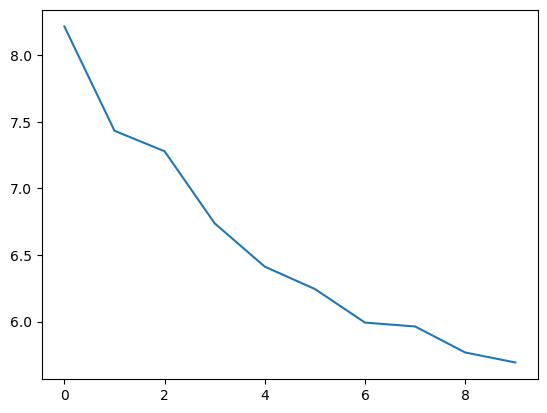

In [26]:
n_epoch = 10
loss_list = []
best_loss = 5000
save_file = os.path.join(opt.save_folder + 'models', 'last.pth')
#save_model(model, optimizer, opt, opt.epochs, save_file)

for epoch in range(1, n_epoch + 1):
    #loss = train_ss(Net,projection_head,unlabelled_train_loader, epoch, print_freq = 50)
    loss = train_combined(Net, projection_head, train_loader, epoch, print_freq=20)
    print(f'Epoch {epoch:3d}, Loss: {loss:.4f}')
    scheduler.step()
    loss_list.append(loss)
    if loss<best_loss:
        best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_best_loss.pth.tar') 
        #save_model_unsupervised(Net, projection_head, '/kaggle/working/unsupervised/best_loss.pth')
        save_model(Net, optimizer, opt, opt.epochs, '/kaggle/working/unsupervised/best_loss.pth')
    if epoch % 5 == 0:
        #best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_checkpoint.pth.tar') 
        save_model_unsupervised(Net, projection_head, f'/kaggle/working/unsupervised/w5_epoch{epoch}.pth')
        #save_model(Net, optimizer, opt, opt.epochs, f'/kaggle/working/unsupervised/w2_epoch{epoch}.pth')
    if epoch % 1003 == 0:
        unlabelled_train_loader = set_unlabel_loader(opt, np.random.randint(1, 100000), unlabel_count)
        print("Dataset changed, indices =", unlabelled_train_loader.sampler.indices)
        
#torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_final_checkpoint.pth.tar') 
plt.figure()
plt.plot(loss_list)

In [27]:
torch.cuda.empty_cache()

In [28]:
optimizer = torch.optim.Adam(list(Net.parameters())+list(projection_head.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

Train: [1][50/391]	
Train: [1][100/391]	
Train: [1][150/391]	
Train: [1][200/391]	
Train: [1][250/391]	
Train: [1][300/391]	
Train: [1][350/391]	
Epoch   1, Loss: 0.7320
==> Saving...
Train: [2][50/391]	
Train: [2][100/391]	
Train: [2][150/391]	
Train: [2][200/391]	
Train: [2][250/391]	
Train: [2][300/391]	
Train: [2][350/391]	
Epoch   2, Loss: 0.5859
==> Saving...
Train: [3][50/391]	
Train: [3][100/391]	
Train: [3][150/391]	
Train: [3][200/391]	
Train: [3][250/391]	
Train: [3][300/391]	
Train: [3][350/391]	
Epoch   3, Loss: 0.4933
==> Saving...
Train: [4][50/391]	
Train: [4][100/391]	
Train: [4][150/391]	
Train: [4][200/391]	
Train: [4][250/391]	
Train: [4][300/391]	
Train: [4][350/391]	
Epoch   4, Loss: 0.4295
==> Saving...
==> Saving...
Train: [5][50/391]	
Train: [5][100/391]	
Train: [5][150/391]	
Train: [5][200/391]	
Train: [5][250/391]	
Train: [5][300/391]	
Train: [5][350/391]	
Epoch   5, Loss: 0.3775
==> Saving...
Train: [6][50/391]	
Train: [6][100/391]	
Train: [6][150/391]	
Trai

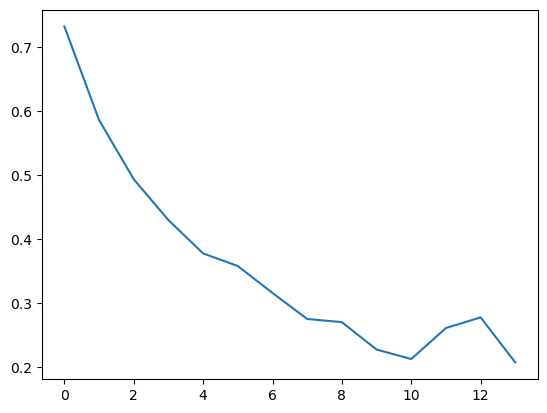

In [29]:
n_epoch = 14
loss_list = []
best_loss = 5000
save_file = os.path.join(opt.save_folder + 'models', 'last.pth')
#save_model(model, optimizer, opt, opt.epochs, save_file)

for epoch in range(1, n_epoch + 1):
    loss = train_ss(Net,projection_head,unlabelled_train_loader, epoch, print_freq = 50)
    #loss = train_combined(Net, projection_head, train_loader, epoch, print_freq=10)
    print(f'Epoch {epoch:3d}, Loss: {loss:.4f}')
    scheduler.step()
    loss_list.append(loss)
    if loss<best_loss:
        best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_best_loss.pth.tar') 
        #save_model_unsupervised(Net, projection_head, '/kaggle/working/unsupervised/best_loss.pth')
        save_model(Net, optimizer, opt, opt.epochs, '/kaggle/working/best_loss.pth')
    if epoch % 4 == 0:
        #best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_checkpoint.pth.tar') 
        #save_model_unsupervised(Net, projection_head, f'/kaggle/working/unsupervised/epoch{epoch}.pth')
        save_model(Net, optimizer, opt, opt.epochs, f'/kaggle/working/epoch{epoch}.pth')
    if epoch % 1003 == 0:
        #unlabelled_train_loader = set_unlabel_loader(opt, np.random.randint(1, 100000), unlabel_count)
        #print("Dataset changed, indices =", unlabelled_train_loader.sampler.indices)
        loss = train_combined(Net, projection_head, train_loader, epoch, print_freq=20)
        
#torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_final_checkpoint.pth.tar') 
plt.figure()
plt.plot(loss_list)

In [ ]:
#-----------------------------------------------------------
# ---------------evaluate self supervised learning

In [ ]:
Net
Net.eval()
for batch_idx, (x,bio) in enumerate(train_loader): 
    if batch_idx % 10 == 0: print(batch_idx)
    with torch.no_grad():
        embed = Net(x.to(device))
        embed = embed.to('cpu')
        if batch_idx==0:
            embed_list = embed
            img_list = x
            bio_list = bio
        else:
            embed_list = torch.cat((embed_list,embed),axis=0)
            img_list = torch.cat((img_list,x),axis=0)
            bio_list = torch.cat((bio_list, bio), axis = 0)
            
embed_list = torch.flatten(embed_list, start_dim=1, end_dim=- 1)
print(embed_list.shape,img_list.shape, bio_list.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(embed_list.detach().numpy())

# Plot
plt.figure(figsize = (50,50))
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1])

# Add labels to be able to identify the data points
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))

label_points(pd.Series(h_embedded[:,0]), 
            pd.Series(h_embedded[:,1]), 
            pd.Series(annotations), 
            plt.gca()) 


In [ ]:
images = [8322, 7168, 3096, 1199]
fig, ax = plt.subplots(1, 4, figsize = (20, 20))

for i, idx in enumerate(images):
    ax[i].imshow(img_list[idx][0].numpy(), cmap = 'gray')
    ax[i].set_title(bio_list[idx])



In [31]:
torch.cuda.empty_cache()

In [32]:
###### SUPERVISED LEARNING PART 

In [33]:
# If loading pretrained
load_file = "/kaggle/working/unsupervised/best_loss.pth"  # change to model path
device = torch.device("cuda:0" )
Net = Encdr().to(device)
Net = load_model(Net, load_file, "model")

==> Loading...


In [34]:
#Net.add_feature()
model, criterion = set_model_st(opt, Net)    
optimizer = set_optimizer(opt, model)

In [35]:
# To check performance without the pre training
#model, criterion = set_model(opt)    
#optimizer = set_optimizer(opt, model)

In [36]:
# training routine with freezing
#model[0].requires_grad_(False)
#opt.learning_rate = 0.05
#for epoch in range(1, 15+1):
#    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)

In [37]:
# training routine without freezing
model[0].requires_grad_(True)
opt.learning_rate = 0.005

best_f1 = 0.6
for epoch in range(1, 80+1):
    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        #submission_generate(test_loader, model, opt, epoch)
        save_file = os.path.join(f'/kaggle/working/supervised/f_epoch_{epoch}.pth')
        save_model(model, optimizer, opt, opt.epochs, save_file)
    
    if epoch % 5 == 0:
        submission_generate(test_loader, model, opt, epoch)
        save_file = os.path.join(f'/kaggle/working/supervised/f_epoch_{epoch}.pth')
        save_model(model, optimizer, opt, opt.epochs, save_file)
    

Train: [1][20/140]	
Train: [1][40/140]	
Train: [1][60/140]	
Train: [1][80/140]	
Train: [1][100/140]	
Train: [1][120/140]	
Train: [1][140/140]	
Training Accuracy: 67.15%
Training loss: 1.2206662773658246
Validation accuracy: 69.65986394557822 %
Validation F1: 0.3632055746536098


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [2][20/140]	
Train: [2][40/140]	
Train: [2][60/140]	
Train: [2][80/140]	
Train: [2][100/140]	
Train: [2][120/140]	
Train: [2][140/140]	
Training Accuracy: 70.76%
Training loss: 0.5542022588943307
Validation accuracy: 66.22448979591836 %
Validation F1: 0.35924712015523


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [3][20/140]	
Train: [3][40/140]	
Train: [3][60/140]	
Train: [3][80/140]	
Train: [3][100/140]	
Train: [3][120/140]	
Train: [3][140/140]	
Training Accuracy: 71.70%
Training loss: 0.539672004385202
Validation accuracy: 72.44897959183673 %
Validation F1: 0.4068357442960309


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [4][20/140]	
Train: [4][40/140]	
Train: [4][60/140]	
Train: [4][80/140]	
Train: [4][100/140]	
Train: [4][120/140]	
Train: [4][140/140]	
Training Accuracy: 73.18%
Training loss: 0.5244425415698657
Validation accuracy: 72.89115646258504 %
Validation F1: 0.43397532428920144


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [5][20/140]	
Train: [5][40/140]	
Train: [5][60/140]	
Train: [5][80/140]	
Train: [5][100/140]	
Train: [5][120/140]	
Train: [5][140/140]	
Training Accuracy: 74.19%
Training loss: 0.510166434101204
Validation accuracy: 71.80272108843538 %
Validation F1: 0.47096226839283073
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [6][20/140]	
Train: [6][40/140]	
Train: [6][60/140]	
Train: [6][80/140]	
Train: [6][100/140]	
Train: [6][120/140]	
Train: [6][140/140]	
Training Accuracy: 75.24%
Training loss: 0.4976583329998717
Validation accuracy: 74.18367346938776 %
Validation F1: 0.4321377712305326


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [7][20/140]	
Train: [7][40/140]	
Train: [7][60/140]	
Train: [7][80/140]	
Train: [7][100/140]	
Train: [7][120/140]	
Train: [7][140/140]	
Training Accuracy: 75.97%
Training loss: 0.4855422865157439
Validation accuracy: 71.05442176870748 %
Validation F1: 0.40679553171680355


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [8][20/140]	
Train: [8][40/140]	
Train: [8][60/140]	
Train: [8][80/140]	
Train: [8][100/140]	
Train: [8][120/140]	
Train: [8][140/140]	
Training Accuracy: 76.49%
Training loss: 0.4813490687771532
Validation accuracy: 73.94557823129252 %
Validation F1: 0.443825582358454


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [9][20/140]	
Train: [9][40/140]	
Train: [9][60/140]	
Train: [9][80/140]	
Train: [9][100/140]	
Train: [9][120/140]	
Train: [9][140/140]	
Training Accuracy: 77.10%
Training loss: 0.47375802105252157
Validation accuracy: 71.9047619047619 %
Validation F1: 0.4343080524142862


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [10][20/140]	
Train: [10][40/140]	
Train: [10][60/140]	
Train: [10][80/140]	
Train: [10][100/140]	
Train: [10][120/140]	
Train: [10][140/140]	
Training Accuracy: 77.14%
Training loss: 0.47377486005976854
Validation accuracy: 73.09523809523809 %
Validation F1: 0.44639479095961504
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [11][20/140]	
Train: [11][40/140]	
Train: [11][60/140]	
Train: [11][80/140]	
Train: [11][100/140]	
Train: [11][120/140]	
Train: [11][140/140]	
Training Accuracy: 77.52%
Training loss: 0.467260057267439
Validation accuracy: 76.08843537414965 %
Validation F1: 0.41779870852433154


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [12][20/140]	
Train: [12][40/140]	
Train: [12][60/140]	
Train: [12][80/140]	
Train: [12][100/140]	
Train: [12][120/140]	
Train: [12][140/140]	
Training Accuracy: 77.84%
Training loss: 0.46157526778757746
Validation accuracy: 72.75510204081633 %
Validation F1: 0.43939928027878933


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [13][20/140]	
Train: [13][40/140]	
Train: [13][60/140]	
Train: [13][80/140]	
Train: [13][100/140]	
Train: [13][120/140]	
Train: [13][140/140]	
Training Accuracy: 78.21%
Training loss: 0.45841233143894144
Validation accuracy: 74.5578231292517 %
Validation F1: 0.47201247729618984


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [14][20/140]	
Train: [14][40/140]	
Train: [14][60/140]	
Train: [14][80/140]	
Train: [14][100/140]	
Train: [14][120/140]	
Train: [14][140/140]	
Training Accuracy: 78.30%
Training loss: 0.455155222585421
Validation accuracy: 68.5374149659864 %
Validation F1: 0.38129064829123566


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [15][20/140]	
Train: [15][40/140]	
Train: [15][60/140]	
Train: [15][80/140]	
Train: [15][100/140]	
Train: [15][120/140]	
Train: [15][140/140]	
Training Accuracy: 78.33%
Training loss: 0.45217825161231745
Validation accuracy: 63.60544217687075 %
Validation F1: 0.39019076066000924
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [16][20/140]	
Train: [16][40/140]	
Train: [16][60/140]	
Train: [16][80/140]	
Train: [16][100/140]	
Train: [16][120/140]	
Train: [16][140/140]	
Training Accuracy: 78.62%
Training loss: 0.44812427109254
Validation accuracy: 75.61224489795919 %
Validation F1: 0.4468288018155675


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [17][20/140]	
Train: [17][40/140]	
Train: [17][60/140]	
Train: [17][80/140]	
Train: [17][100/140]	
Train: [17][120/140]	
Train: [17][140/140]	
Training Accuracy: 78.88%
Training loss: 0.4453312114673122
Validation accuracy: 74.89795918367346 %
Validation F1: 0.46164935165591364


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [18][20/140]	
Train: [18][40/140]	
Train: [18][60/140]	
Train: [18][80/140]	
Train: [18][100/140]	
Train: [18][120/140]	
Train: [18][140/140]	
Training Accuracy: 78.79%
Training loss: 0.4431804190518263
Validation accuracy: 70.68027210884354 %
Validation F1: 0.4200576621596657


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [19][20/140]	
Train: [19][40/140]	
Train: [19][60/140]	
Train: [19][80/140]	
Train: [19][100/140]	
Train: [19][120/140]	
Train: [19][140/140]	
Training Accuracy: 78.91%
Training loss: 0.44349077623984984
Validation accuracy: 75.47619047619048 %
Validation F1: 0.45948568630299863


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [20][20/140]	
Train: [20][40/140]	
Train: [20][60/140]	
Train: [20][80/140]	
Train: [20][100/140]	
Train: [20][120/140]	
Train: [20][140/140]	
Training Accuracy: 79.07%
Training loss: 0.4420582216185394
Validation accuracy: 75.40816326530613 %
Validation F1: 0.45543476475056316
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [21][20/140]	
Train: [21][40/140]	
Train: [21][60/140]	
Train: [21][80/140]	
Train: [21][100/140]	
Train: [21][120/140]	
Train: [21][140/140]	
Training Accuracy: 79.15%
Training loss: 0.4347940535322383
Validation accuracy: 69.93197278911565 %
Validation F1: 0.43559538135785747


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [22][20/140]	
Train: [22][40/140]	
Train: [22][60/140]	
Train: [22][80/140]	
Train: [22][100/140]	
Train: [22][120/140]	
Train: [22][140/140]	
Training Accuracy: 79.28%
Training loss: 0.43783060256930634
Validation accuracy: 75.81632653061224 %
Validation F1: 0.44269584026274417


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [23][20/140]	
Train: [23][40/140]	
Train: [23][60/140]	
Train: [23][80/140]	
Train: [23][100/140]	
Train: [23][120/140]	
Train: [23][140/140]	
Training Accuracy: 79.50%
Training loss: 0.4369030064613088
Validation accuracy: 75.0 %
Validation F1: 0.45299272690519765


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [24][20/140]	
Train: [24][40/140]	
Train: [24][60/140]	
Train: [24][80/140]	
Train: [24][100/140]	
Train: [24][120/140]	
Train: [24][140/140]	
Training Accuracy: 79.50%
Training loss: 0.43287752982772876
Validation accuracy: 71.22448979591837 %
Validation F1: 0.47043157073460345


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [25][20/140]	
Train: [25][40/140]	
Train: [25][60/140]	
Train: [25][80/140]	
Train: [25][100/140]	
Train: [25][120/140]	
Train: [25][140/140]	
Training Accuracy: 79.84%
Training loss: 0.429634424115703
Validation accuracy: 75.8843537414966 %
Validation F1: 0.4754321564347433
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [26][20/140]	
Train: [26][40/140]	
Train: [26][60/140]	
Train: [26][80/140]	
Train: [26][100/140]	
Train: [26][120/140]	
Train: [26][140/140]	
Training Accuracy: 80.05%
Training loss: 0.42387202810508623
Validation accuracy: 74.76190476190476 %
Validation F1: 0.4665447350592013


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [27][20/140]	
Train: [27][40/140]	
Train: [27][60/140]	
Train: [27][80/140]	
Train: [27][100/140]	
Train: [27][120/140]	
Train: [27][140/140]	
Training Accuracy: 79.88%
Training loss: 0.4265674903644631
Validation accuracy: 75.95238095238095 %
Validation F1: 0.47697203649025455


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [28][20/140]	
Train: [28][40/140]	
Train: [28][60/140]	
Train: [28][80/140]	
Train: [28][100/140]	
Train: [28][120/140]	
Train: [28][140/140]	
Training Accuracy: 80.06%
Training loss: 0.4232631164044643
Validation accuracy: 72.82312925170068 %
Validation F1: 0.48767126942926486


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [29][20/140]	
Train: [29][40/140]	
Train: [29][60/140]	
Train: [29][80/140]	
Train: [29][100/140]	
Train: [29][120/140]	
Train: [29][140/140]	
Training Accuracy: 80.05%
Training loss: 0.4233153026169206
Validation accuracy: 72.27891156462584 %
Validation F1: 0.4532231678885248


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [30][20/140]	
Train: [30][40/140]	
Train: [30][60/140]	
Train: [30][80/140]	
Train: [30][100/140]	
Train: [30][120/140]	
Train: [30][140/140]	
Training Accuracy: 80.19%
Training loss: 0.4208518620910439
Validation accuracy: 76.56462585034014 %
Validation F1: 0.48104936693462896
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [31][20/140]	
Train: [31][40/140]	
Train: [31][60/140]	
Train: [31][80/140]	
Train: [31][100/140]	
Train: [31][120/140]	
Train: [31][140/140]	
Training Accuracy: 80.39%
Training loss: 0.4209429515760879
Validation accuracy: 76.66666666666667 %
Validation F1: 0.47383661595377063


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [32][20/140]	
Train: [32][40/140]	
Train: [32][60/140]	
Train: [32][80/140]	
Train: [32][100/140]	
Train: [32][120/140]	
Train: [32][140/140]	
Training Accuracy: 80.39%
Training loss: 0.41886032814
Validation accuracy: 74.8639455782313 %
Validation F1: 0.4696920157475329


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [33][20/140]	
Train: [33][40/140]	
Train: [33][60/140]	
Train: [33][80/140]	
Train: [33][100/140]	
Train: [33][120/140]	
Train: [33][140/140]	
Training Accuracy: 80.42%
Training loss: 0.4155178590790256
Validation accuracy: 75.40816326530613 %
Validation F1: 0.4912664107634306


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [34][20/140]	
Train: [34][40/140]	
Train: [34][60/140]	
Train: [34][80/140]	
Train: [34][100/140]	
Train: [34][120/140]	
Train: [34][140/140]	
Training Accuracy: 80.41%
Training loss: 0.416317198971083
Validation accuracy: 74.8639455782313 %
Validation F1: 0.48646998819149306


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [35][20/140]	
Train: [35][40/140]	
Train: [35][60/140]	
Train: [35][80/140]	
Train: [35][100/140]	
Train: [35][120/140]	
Train: [35][140/140]	
Training Accuracy: 80.58%
Training loss: 0.41364193786070147
Validation accuracy: 75.27210884353741 %
Validation F1: 0.4802306677985735
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [36][20/140]	
Train: [36][40/140]	
Train: [36][60/140]	
Train: [36][80/140]	
Train: [36][100/140]	
Train: [36][120/140]	
Train: [36][140/140]	
Training Accuracy: 80.69%
Training loss: 0.4136474493253549
Validation accuracy: 76.25850340136054 %
Validation F1: 0.49653369734596103


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [37][20/140]	
Train: [37][40/140]	
Train: [37][60/140]	
Train: [37][80/140]	
Train: [37][100/140]	
Train: [37][120/140]	
Train: [37][140/140]	
Training Accuracy: 80.84%
Training loss: 0.4107485470228544
Validation accuracy: 76.73469387755102 %
Validation F1: 0.4985997610953634


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [38][20/140]	
Train: [38][40/140]	
Train: [38][60/140]	
Train: [38][80/140]	
Train: [38][100/140]	
Train: [38][120/140]	
Train: [38][140/140]	
Training Accuracy: 81.04%
Training loss: 0.4076520371167054
Validation accuracy: 74.96598639455783 %
Validation F1: 0.5225455410929206


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [39][20/140]	
Train: [39][40/140]	
Train: [39][60/140]	
Train: [39][80/140]	
Train: [39][100/140]	
Train: [39][120/140]	
Train: [39][140/140]	
Training Accuracy: 81.20%
Training loss: 0.4066216184382322
Validation accuracy: 77.07482993197279 %
Validation F1: 0.4761295266742353


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [40][20/140]	
Train: [40][40/140]	
Train: [40][60/140]	
Train: [40][80/140]	
Train: [40][100/140]	
Train: [40][120/140]	
Train: [40][140/140]	
Training Accuracy: 80.85%
Training loss: 0.4063498808426503
Validation accuracy: 73.09523809523809 %
Validation F1: 0.4742688333595693
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [41][20/140]	
Train: [41][40/140]	
Train: [41][60/140]	
Train: [41][80/140]	
Train: [41][100/140]	
Train: [41][120/140]	
Train: [41][140/140]	
Training Accuracy: 81.16%
Training loss: 0.40704142201184745
Validation accuracy: 75.71428571428571 %
Validation F1: 0.448815469757012


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [42][20/140]	
Train: [42][40/140]	
Train: [42][60/140]	
Train: [42][80/140]	
Train: [42][100/140]	
Train: [42][120/140]	
Train: [42][140/140]	
Training Accuracy: 81.14%
Training loss: 0.4049182812724848
Validation accuracy: 75.95238095238095 %
Validation F1: 0.5265474562720421


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [43][20/140]	
Train: [43][40/140]	
Train: [43][60/140]	
Train: [43][80/140]	
Train: [43][100/140]	
Train: [43][120/140]	
Train: [43][140/140]	
Training Accuracy: 81.18%
Training loss: 0.40407322211820573
Validation accuracy: 76.19047619047619 %
Validation F1: 0.4978355295797859


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [44][20/140]	
Train: [44][40/140]	
Train: [44][60/140]	
Train: [44][80/140]	
Train: [44][100/140]	
Train: [44][120/140]	
Train: [44][140/140]	
Training Accuracy: 81.32%
Training loss: 0.4022274875846725
Validation accuracy: 74.93197278911565 %
Validation F1: 0.47026324266297986


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [45][20/140]	
Train: [45][40/140]	
Train: [45][60/140]	
Train: [45][80/140]	
Train: [45][100/140]	
Train: [45][120/140]	
Train: [45][140/140]	
Training Accuracy: 81.45%
Training loss: 0.402428167106646
Validation accuracy: 75.20408163265306 %
Validation F1: 0.4914565515040192
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [46][20/140]	
Train: [46][40/140]	
Train: [46][60/140]	
Train: [46][80/140]	
Train: [46][100/140]	
Train: [46][120/140]	
Train: [46][140/140]	
Training Accuracy: 81.82%
Training loss: 0.3976942797590997
Validation accuracy: 73.46938775510205 %
Validation F1: 0.5114269237539938


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [47][20/140]	
Train: [47][40/140]	
Train: [47][60/140]	
Train: [47][80/140]	
Train: [47][100/140]	
Train: [47][120/140]	
Train: [47][140/140]	
Training Accuracy: 81.76%
Training loss: 0.3950004962346671
Validation accuracy: 76.59863945578232 %
Validation F1: 0.5151963891569342


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [48][20/140]	
Train: [48][40/140]	
Train: [48][60/140]	
Train: [48][80/140]	
Train: [48][100/140]	
Train: [48][120/140]	
Train: [48][140/140]	
Training Accuracy: 82.13%
Training loss: 0.39156178478757264
Validation accuracy: 75.64625850340137 %
Validation F1: 0.5331743757137137


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [49][20/140]	
Train: [49][40/140]	
Train: [49][60/140]	
Train: [49][80/140]	
Train: [49][100/140]	
Train: [49][120/140]	
Train: [49][140/140]	
Training Accuracy: 81.93%
Training loss: 0.3941281602291228
Validation accuracy: 76.32653061224491 %
Validation F1: 0.5549868371724553


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [50][20/140]	
Train: [50][40/140]	
Train: [50][60/140]	
Train: [50][80/140]	
Train: [50][100/140]	
Train: [50][120/140]	
Train: [50][140/140]	
Training Accuracy: 81.80%
Training loss: 0.3964586818357251
Validation accuracy: 74.8639455782313 %
Validation F1: 0.5341451934060361
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [51][20/140]	
Train: [51][40/140]	
Train: [51][60/140]	
Train: [51][80/140]	
Train: [51][100/140]	
Train: [51][120/140]	
Train: [51][140/140]	
Training Accuracy: 82.08%
Training loss: 0.3910274611483991
Validation accuracy: 76.87074829931973 %
Validation F1: 0.5732900198912979


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [52][20/140]	
Train: [52][40/140]	
Train: [52][60/140]	
Train: [52][80/140]	
Train: [52][100/140]	
Train: [52][120/140]	
Train: [52][140/140]	
Training Accuracy: 82.22%
Training loss: 0.38771896776422626
Validation accuracy: 73.40136054421768 %
Validation F1: 0.5232586765416553


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [53][20/140]	
Train: [53][40/140]	
Train: [53][60/140]	
Train: [53][80/140]	
Train: [53][100/140]	
Train: [53][120/140]	
Train: [53][140/140]	
Training Accuracy: 82.16%
Training loss: 0.3896999579958115
Validation accuracy: 75.95238095238095 %
Validation F1: 0.5232753003570197


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [54][20/140]	
Train: [54][40/140]	
Train: [54][60/140]	
Train: [54][80/140]	
Train: [54][100/140]	
Train: [54][120/140]	
Train: [54][140/140]	
Training Accuracy: 82.45%
Training loss: 0.38372019207993546
Validation accuracy: 77.24489795918367 %
Validation F1: 0.5360233028855645


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [55][20/140]	
Train: [55][40/140]	
Train: [55][60/140]	
Train: [55][80/140]	
Train: [55][100/140]	
Train: [55][120/140]	
Train: [55][140/140]	
Training Accuracy: 82.49%
Training loss: 0.3841595442793941
Validation accuracy: 77.27891156462586 %
Validation F1: 0.5857341605249303
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [56][20/140]	
Train: [56][40/140]	
Train: [56][60/140]	
Train: [56][80/140]	
Train: [56][100/140]	
Train: [56][120/140]	
Train: [56][140/140]	
Training Accuracy: 82.67%
Training loss: 0.38242252428693657
Validation accuracy: 75.81632653061224 %
Validation F1: 0.5457356274483298


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [57][20/140]	
Train: [57][40/140]	
Train: [57][60/140]	
Train: [57][80/140]	
Train: [57][100/140]	
Train: [57][120/140]	
Train: [57][140/140]	
Training Accuracy: 82.63%
Training loss: 0.38201464833927734
Validation accuracy: 73.74149659863946 %
Validation F1: 0.5080524946203685


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [58][20/140]	
Train: [58][40/140]	
Train: [58][60/140]	
Train: [58][80/140]	
Train: [58][100/140]	
Train: [58][120/140]	
Train: [58][140/140]	
Training Accuracy: 82.58%
Training loss: 0.38352032844248735
Validation accuracy: 73.40136054421768 %
Validation F1: 0.49569783404241247


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [59][20/140]	
Train: [59][40/140]	
Train: [59][60/140]	
Train: [59][80/140]	
Train: [59][100/140]	
Train: [59][120/140]	
Train: [59][140/140]	
Training Accuracy: 82.68%
Training loss: 0.3821820479440272
Validation accuracy: 76.49659863945578 %
Validation F1: 0.5650060969767717


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [60][20/140]	
Train: [60][40/140]	
Train: [60][60/140]	
Train: [60][80/140]	
Train: [60][100/140]	
Train: [60][120/140]	
Train: [60][140/140]	
Training Accuracy: 82.57%
Training loss: 0.3806616835769021
Validation accuracy: 75.74829931972789 %
Validation F1: 0.5522349152997496
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [61][20/140]	
Train: [61][40/140]	
Train: [61][60/140]	
Train: [61][80/140]	
Train: [61][100/140]	
Train: [61][120/140]	
Train: [61][140/140]	
Training Accuracy: 82.66%
Training loss: 0.3834618912413666
Validation accuracy: 77.58503401360545 %
Validation F1: 0.5031286534347009


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [62][20/140]	
Train: [62][40/140]	
Train: [62][60/140]	
Train: [62][80/140]	
Train: [62][100/140]	
Train: [62][120/140]	
Train: [62][140/140]	
Training Accuracy: 83.00%
Training loss: 0.37462456145744255
Validation accuracy: 77.75510204081633 %
Validation F1: 0.5779645305485696


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [63][20/140]	
Train: [63][40/140]	
Train: [63][60/140]	
Train: [63][80/140]	
Train: [63][100/140]	
Train: [63][120/140]	
Train: [63][140/140]	
Training Accuracy: 83.05%
Training loss: 0.37408647695098873
Validation accuracy: 76.90476190476191 %
Validation F1: 0.533361455908299


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [64][20/140]	
Train: [64][40/140]	
Train: [64][60/140]	
Train: [64][80/140]	
Train: [64][100/140]	
Train: [64][120/140]	
Train: [64][140/140]	
Training Accuracy: 82.90%
Training loss: 0.37578670098712613
Validation accuracy: 77.99319727891157 %
Validation F1: 0.5563435456711116


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [65][20/140]	
Train: [65][40/140]	
Train: [65][60/140]	
Train: [65][80/140]	
Train: [65][100/140]	
Train: [65][120/140]	
Train: [65][140/140]	
Training Accuracy: 83.46%
Training loss: 0.37206116151611857
Validation accuracy: 78.06122448979592 %
Validation F1: 0.5921437180710775
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [66][20/140]	
Train: [66][40/140]	
Train: [66][60/140]	
Train: [66][80/140]	
Train: [66][100/140]	
Train: [66][120/140]	
Train: [66][140/140]	
Training Accuracy: 83.15%
Training loss: 0.3734341290973446
Validation accuracy: 75.03401360544217 %
Validation F1: 0.5170155535150109


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [67][20/140]	
Train: [67][40/140]	
Train: [67][60/140]	
Train: [67][80/140]	
Train: [67][100/140]	
Train: [67][120/140]	
Train: [67][140/140]	
Training Accuracy: 83.13%
Training loss: 0.3708304198340574
Validation accuracy: 78.33333333333333 %
Validation F1: 0.5922124431154066


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [68][20/140]	
Train: [68][40/140]	
Train: [68][60/140]	
Train: [68][80/140]	
Train: [68][100/140]	
Train: [68][120/140]	
Train: [68][140/140]	
Training Accuracy: 83.15%
Training loss: 0.371470025493896
Validation accuracy: 76.22448979591837 %
Validation F1: 0.5338267521695473


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [69][20/140]	
Train: [69][40/140]	
Train: [69][60/140]	
Train: [69][80/140]	
Train: [69][100/140]	
Train: [69][120/140]	
Train: [69][140/140]	
Training Accuracy: 83.06%
Training loss: 0.37374783056844746
Validation accuracy: 80.4421768707483 %
Validation F1: 0.6122389711210038
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [70][20/140]	
Train: [70][40/140]	
Train: [70][60/140]	
Train: [70][80/140]	
Train: [70][100/140]	
Train: [70][120/140]	
Train: [70][140/140]	
Training Accuracy: 83.68%
Training loss: 0.3643641691486994
Validation accuracy: 77.14285714285715 %
Validation F1: 0.5661979007290981
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [71][20/140]	
Train: [71][40/140]	
Train: [71][60/140]	
Train: [71][80/140]	
Train: [71][100/140]	
Train: [71][120/140]	
Train: [71][140/140]	
Training Accuracy: 83.75%
Training loss: 0.3625871798307218
Validation accuracy: 75.10204081632654 %
Validation F1: 0.5350908515196919


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [72][20/140]	
Train: [72][40/140]	
Train: [72][60/140]	
Train: [72][80/140]	
Train: [72][100/140]	
Train: [72][120/140]	
Train: [72][140/140]	
Training Accuracy: 83.43%
Training loss: 0.36602815519161996
Validation accuracy: 77.44897959183673 %
Validation F1: 0.5927465691644968


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [73][20/140]	
Train: [73][40/140]	
Train: [73][60/140]	
Train: [73][80/140]	
Train: [73][100/140]	
Train: [73][120/140]	
Train: [73][140/140]	
Training Accuracy: 83.54%
Training loss: 0.3626400938374121
Validation accuracy: 77.61904761904762 %
Validation F1: 0.5732116764199829


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [74][20/140]	
Train: [74][40/140]	
Train: [74][60/140]	
Train: [74][80/140]	
Train: [74][100/140]	
Train: [74][120/140]	
Train: [74][140/140]	
Training Accuracy: 83.84%
Training loss: 0.3621119503403865
Validation accuracy: 77.99319727891157 %
Validation F1: 0.5783411198218832


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [75][20/140]	
Train: [75][40/140]	
Train: [75][60/140]	
Train: [75][80/140]	
Train: [75][100/140]	
Train: [75][120/140]	
Train: [75][140/140]	
Training Accuracy: 83.78%
Training loss: 0.3589313267110896
Validation accuracy: 77.41496598639456 %
Validation F1: 0.5604087382547192
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [76][20/140]	
Train: [76][40/140]	
Train: [76][60/140]	
Train: [76][80/140]	
Train: [76][100/140]	
Train: [76][120/140]	
Train: [76][140/140]	
Training Accuracy: 83.79%
Training loss: 0.35945960974901825
Validation accuracy: 78.46938775510203 %
Validation F1: 0.5507967054672214


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [77][20/140]	
Train: [77][40/140]	
Train: [77][60/140]	
Train: [77][80/140]	
Train: [77][100/140]	
Train: [77][120/140]	
Train: [77][140/140]	
Training Accuracy: 83.79%
Training loss: 0.3602999512671783
Validation accuracy: 77.7891156462585 %
Validation F1: 0.5471745571752873


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [78][20/140]	
Train: [78][40/140]	
Train: [78][60/140]	
Train: [78][80/140]	
Train: [78][100/140]	
Train: [78][120/140]	
Train: [78][140/140]	
Training Accuracy: 83.77%
Training loss: 0.3602902493246416
Validation accuracy: 80.17006802721089 %
Validation F1: 0.5982311840206577


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [79][20/140]	
Train: [79][40/140]	
Train: [79][60/140]	
Train: [79][80/140]	
Train: [79][100/140]	
Train: [79][120/140]	
Train: [79][140/140]	
Training Accuracy: 83.75%
Training loss: 0.3551765282169055
Validation accuracy: 75.85034013605441 %
Validation F1: 0.5516496456426715


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [80][20/140]	
Train: [80][40/140]	
Train: [80][60/140]	
Train: [80][80/140]	
Train: [80][100/140]	
Train: [80][120/140]	
Train: [80][140/140]	
Training Accuracy: 84.21%
Training loss: 0.3552123497061249
Validation accuracy: 79.21768707482994 %
Validation F1: 0.5593739088167974
==> Saving...


In [38]:
save_file = os.path.join('/kaggle/working/supervised/last.pth')
save_model(model, optimizer, opt, opt.epochs, save_file)

==> Saving...


In [39]:
# Validation
sample_evaluation(val_loader, model, opt)

Validation accuracy: 79.21768707482994 %
Validation F1: 0.5593739088167974


0.5593739088167974

In [40]:
submission_generate(test_loader, model, opt)

In [41]:
# training routine without freezing
model[0].requires_grad_(True)
opt.learning_rate = 0.005

best_f1 = 0.6
for epoch in range(81, 90+1):
    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        submission_generate(test_loader, model, opt, epoch)
        save_file = os.path.join(f'/kaggle/working/supervised/f_epoch_{epoch}.pth')
        save_model(model, optimizer, opt, opt.epochs, save_file)
    
    if epoch % 5 == 0:
        submission_generate(test_loader, model, opt, epoch)
        save_file = os.path.join(f'/kaggle/working/supervised/f_epoch_{epoch}.pth')
        save_model(model, optimizer, opt, opt.epochs, save_file)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [81][20/140]	
Train: [81][40/140]	
Train: [81][60/140]	
Train: [81][80/140]	
Train: [81][100/140]	
Train: [81][120/140]	
Train: [81][140/140]	
Training Accuracy: 83.96%
Training loss: 0.3547618683677373
Validation accuracy: 80.54421768707482 %
Validation F1: 0.6153431079167083
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [82][20/140]	
Train: [82][40/140]	
Train: [82][60/140]	
Train: [82][80/140]	
Train: [82][100/140]	
Train: [82][120/140]	
Train: [82][140/140]	
Training Accuracy: 84.25%
Training loss: 0.35224218989707184
Validation accuracy: 78.77551020408163 %
Validation F1: 0.6106228942968118
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [83][20/140]	
Train: [83][40/140]	
Train: [83][60/140]	
Train: [83][80/140]	
Train: [83][100/140]	
Train: [83][120/140]	
Train: [83][140/140]	
Training Accuracy: 84.22%
Training loss: 0.35029516655330994
Validation accuracy: 79.04761904761905 %
Validation F1: 0.5833562296151372


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [84][20/140]	
Train: [84][40/140]	
Train: [84][60/140]	
Train: [84][80/140]	
Train: [84][100/140]	
Train: [84][120/140]	
Train: [84][140/140]	
Training Accuracy: 84.30%
Training loss: 0.35205226891322583
Validation accuracy: 77.85714285714286 %
Validation F1: 0.5410882736180738


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [85][20/140]	
Train: [85][40/140]	
Train: [85][60/140]	
Train: [85][80/140]	
Train: [85][100/140]	
Train: [85][120/140]	
Train: [85][140/140]	
Training Accuracy: 84.31%
Training loss: 0.34980482757960396
Validation accuracy: 77.68707482993197 %
Validation F1: 0.5114563207967928
==> Saving...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [86][20/140]	
Train: [86][40/140]	
Train: [86][60/140]	
Train: [86][80/140]	
Train: [86][100/140]	
Train: [86][120/140]	
Train: [86][140/140]	
Training Accuracy: 84.73%
Training loss: 0.3461224349471693
Validation accuracy: 78.843537414966 %
Validation F1: 0.5535610676228311


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [87][20/140]	
Train: [87][40/140]	
Train: [87][60/140]	
Train: [87][80/140]	
Train: [87][100/140]	
Train: [87][120/140]	
Train: [87][140/140]	
Training Accuracy: 84.54%
Training loss: 0.3467886056379236
Validation accuracy: 77.82312925170068 %
Validation F1: 0.5233300504211909


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [88][20/140]	
Train: [88][40/140]	
Train: [88][60/140]	
Train: [88][80/140]	
Train: [88][100/140]	
Train: [88][120/140]	
Train: [88][140/140]	
Training Accuracy: 84.53%
Training loss: 0.347378740712489
Validation accuracy: 78.57142857142857 %
Validation F1: 0.5564202431135837


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [89][20/140]	
Train: [89][40/140]	
Train: [89][60/140]	
Train: [89][80/140]	
Train: [89][100/140]	
Train: [89][120/140]	
Train: [89][140/140]	
Training Accuracy: 84.67%
Training loss: 0.344360863575622
Validation accuracy: 79.31972789115646 %
Validation F1: 0.574247923555895


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [90][20/140]	
Train: [90][40/140]	
Train: [90][60/140]	
Train: [90][80/140]	
Train: [90][100/140]	
Train: [90][120/140]	
Train: [90][140/140]	
Training Accuracy: 84.50%
Training loss: 0.3449576673926888
Validation accuracy: 77.00680272108843 %
Validation F1: 0.5383774858293269
==> Saving...
